In [9]:
import numpy as np 
import scipy #intégrer et générer les cdf et pdf de beta 

## Binomial bandit 

In [2]:
#générer les theta 
k = 3
theta = np.random.uniform(0,1,k)

In [3]:
def f(a,theta): 
    return np.random.binomial(1, theta[a])

In [4]:
# case mu_a(theta)=theta_a (binomial bandit)
def I(a,theta): 
    if theta[a]== max(theta): 
        return 1
    return 0

In [75]:
# Python code for computing Equation (11) by quadrature.
#NOT WORKING AT THIS TIME
def compute_probopt(Y_t, N_t): 
    k = len(Y_t)
    ans = np.zeros(k)
    for i in range(k): 
        def fct_to_integrate(x):
            r = scipy.stats.beta.cdf(x, Y_t[i]+1, N_t[i]-Y_t[i]+1)
            for j in range(k): 
                if i!=j: 
                    r = r * scipy.stats.beta.cdf(x, Y_t[j]+1, N_t[j]-Y_t[j]+1)
            return r
        ans[i] = scipy.integrate.quad(fct_to_integrate, 0, 1)
    return ans                

In [64]:
# Python code for computing Equation (11) by simulation.
# Function to simulate posterior samples
def sim_post(Y_t, N_t, ndraws):
    k = len(Y_t)
    ans = np.zeros((ndraws, k))
    No = N_t - Y_t
    for i in range(k):
        ans[:, i] = scipy.stats.beta.rvs(Y_t[i] + 1, No[i] + 1, size=ndraws)
    return ans

# Function to calculate the probability of a winner
def prob_winner(post):
    k = post.shape[1]
    w = np.bincount(np.argmax(post, axis=1), minlength=k)
    return w / np.sum(w)

# Function to compute the winning probabilities
def compute_win_prob(Y_t, N_t, ndraws):
    post = sim_post(Y_t, N_t, ndraws)
    return prob_winner(post)

In [95]:
def run_experiment(n_arms, n_trials, true_success_probs, strategy="rpm"):
    """Simule une expérience avec RPM ou Equal Allocation."""
    optimal_reward = max(true_success_probs)

    Y_t = np.zeros(n_arms)  # Succès cumulatifs observés pour chaque bras
    N_t = np.zeros(n_arms)  # Nombre total cumulatifs de tirages pour chaque bras
    
    n_prior_obs = 10**6
    champion_index = 0
    N_t[champion_index] = n_prior_obs
    prior_obs = np.random.rand(n_prior_obs) < true_success_probs[champion_index]
    Y_t[champion_index] = np.sum(prior_obs)

    regrets = []
    
    for t in range(1, n_trials + 1):
        n_observations = np.random.poisson(1000)

        # Calculer les probabilités d'optimalité
        win_probs = compute_win_prob(Y_t, N_t, 100)
        if strategy=="rpm":
            chosen_arm = np.random.choice(range(1,n_arms+1), p=win_probs, size=n_observations)
        if strategy=="equal allocation":
            chosen_arm = np.random.choice(range(1,n_arms+1), p=[1/n_arms]*n_arms, size=n_observations)

        # Actualiser N_t, remplir n_t
        np.add.at(N_t, chosen_arm-1, 1)
        n_t = np.zeros(n_arms)  # Nombre total de tirages pour chaque bras 
        np.add.at(n_t, chosen_arm-1, 1)

        # Actualiser Y_t et calculer le regret 
        regret_t = 0
        for a in range(n_arms):
            obs = np.random.rand(int(n_t[a])) < true_success_probs[a]
            Y_t[a] += np.sum(obs)

            regret_t +=  n_t[a]*(optimal_reward - true_success_probs[a])
        regrets.append(regret_t)
        
        if max(win_probs)>0.95: 
            break

    
    return regrets

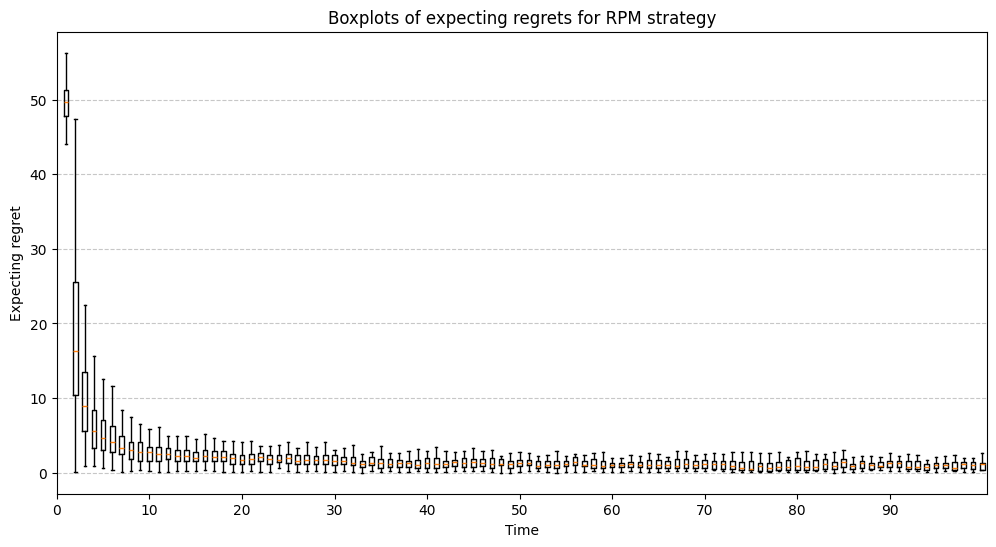

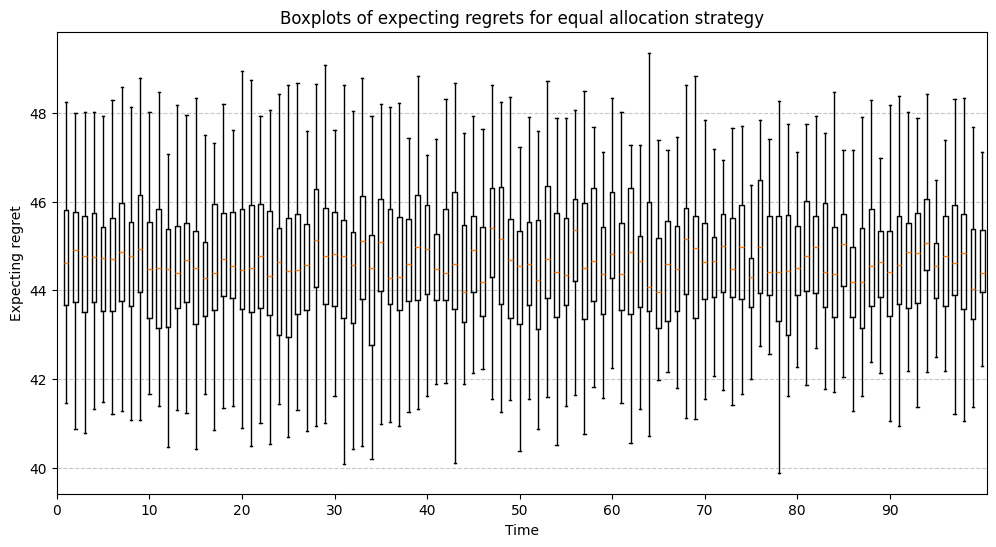

In [96]:
import numpy as np
import matplotlib.pyplot as plt
# Paramètres du problème
#np.random.seed(42)
n_arms = 10
n_trials = 100
n_experiments = 100
  # Nombre de tirages pour estimer les probabilités d'optimalité

# Générer les vraies probabilités de succès
true_success_probs = np.random.uniform(0, 1/10, n_arms)

rpm_regrets = []
equal_allocation_regrets = []

for _ in range(n_experiments):
    rpm_regrets.append(run_experiment(n_arms, n_trials, true_success_probs, strategy="rpm"))
    equal_allocation_regrets.append(run_experiment(n_arms, n_trials, true_success_probs, strategy="equal allocation"))



# Regrouper les données par période
def group_by_period(experiment_data):
  period_data = [[] for _ in range(max(len(lst) for lst in experiment_data))]
  for lst in experiment_data:
      for i, value in enumerate(lst):
          period_data[i].append(value)
  return period_data

rpm_period_data = group_by_period(rpm_regrets)
equal_allocation_period_data = group_by_period(equal_allocation_regrets)


# Créer le boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(rpm_period_data, showfliers=False)  # showfliers=False pour ne pas afficher les outliers
plt.title("Boxplots of expecting regrets for RPM strategy")
plt.xlabel("Time")
plt.ylabel("Expecting regret")
plt.xticks(ticks=range(0, 100, 10), labels=range(0, 100, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Créer le boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(equal_allocation_period_data, showfliers=False)  # showfliers=False pour ne pas afficher les outliers
plt.title("Boxplots of expecting regrets for equal allocation strategy")
plt.xlabel("Time")
plt.ylabel("Expecting regret")
plt.xticks(ticks=range(0, 100, 10), labels=range(0, 100, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()